# 1. Initialisation du Dataset

## 1.1. Importer le Dataset

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Sleep_Data_Sampled.csv")

## 1.2. Vérification du Dataset

In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                15000 non-null  int64  
 1   Gender                   15000 non-null  object 
 2   Age                      15000 non-null  int64  
 3   Occupation               15000 non-null  object 
 4   Sleep Duration           15000 non-null  float64
 5   Quality of Sleep         15000 non-null  int64  
 6   Physical Activity Level  15000 non-null  int64  
 7   Stress Level             15000 non-null  int64  
 8   BMI Category             15000 non-null  object 
 9   Blood Pressure           15000 non-null  object 
 10  Heart Rate               15000 non-null  int64  
 11  Daily Steps              15000 non-null  int64  
 12  Sleep Disorder           15000 non-null  object 
dtypes: float64(1), int64(7), object(5)
memory usage: 1.5+ MB


,Person ID,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7500.500000,44.130667,6.997327,7.131267,59.925000,5.654800,70.857533,6795.080000
std,4330.271354,6.840091,0.615187,1.053111,16.814374,1.393568,3.614836,1329.706484
min,1.000000,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000
25%,3750.750000,40.000000,6.500000,6.000000,45.000000,4.000000,68.000000,6000.000000
50%,7500.500000,44.000000,7.000000,7.000000,60.000000,6.000000,70.000000,6500.000000
75%,11250.250000,48.000000,7.450000,8.000000,75.000000,6.000000,72.000000,7600.000000
max,15000.000000,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000


# 2. Premiers graphes
## 2.1. Histogrammes pour voir la distribution des variables numériques

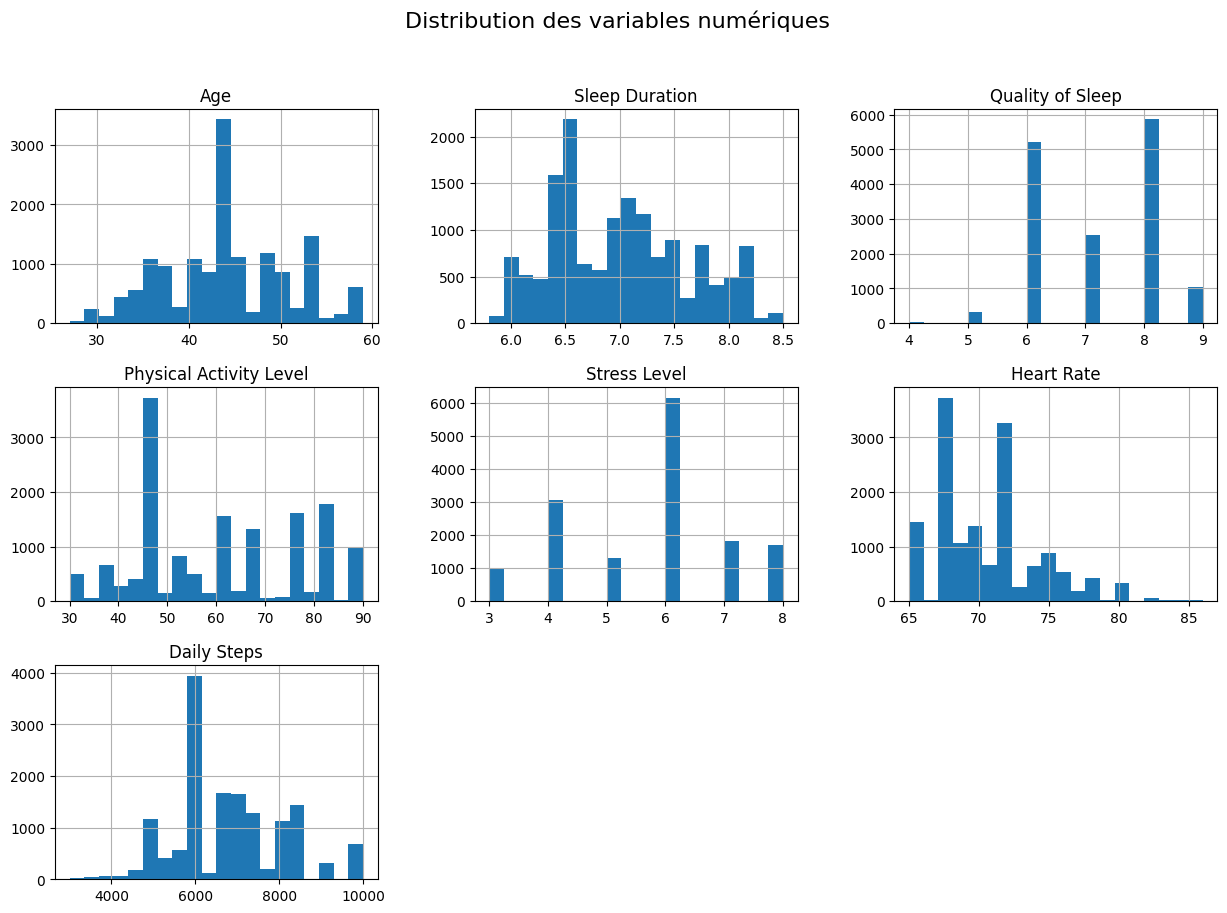

In [4]:
# Histogrammes pour voir la distribution des variables numériques
numerical_cols = ['Age', 'Sleep Duration', 'Quality of Sleep',
                  'Physical Activity Level', 'Stress Level',
                  'Heart Rate', 'Daily Steps']

df[numerical_cols].hist(bins=20, figsize=(15,10))
plt.suptitle("Distribution des variables numériques", fontsize=16)
plt.show()

## 2.2. Boxplots pour comparer les variables numériques selon le sexe


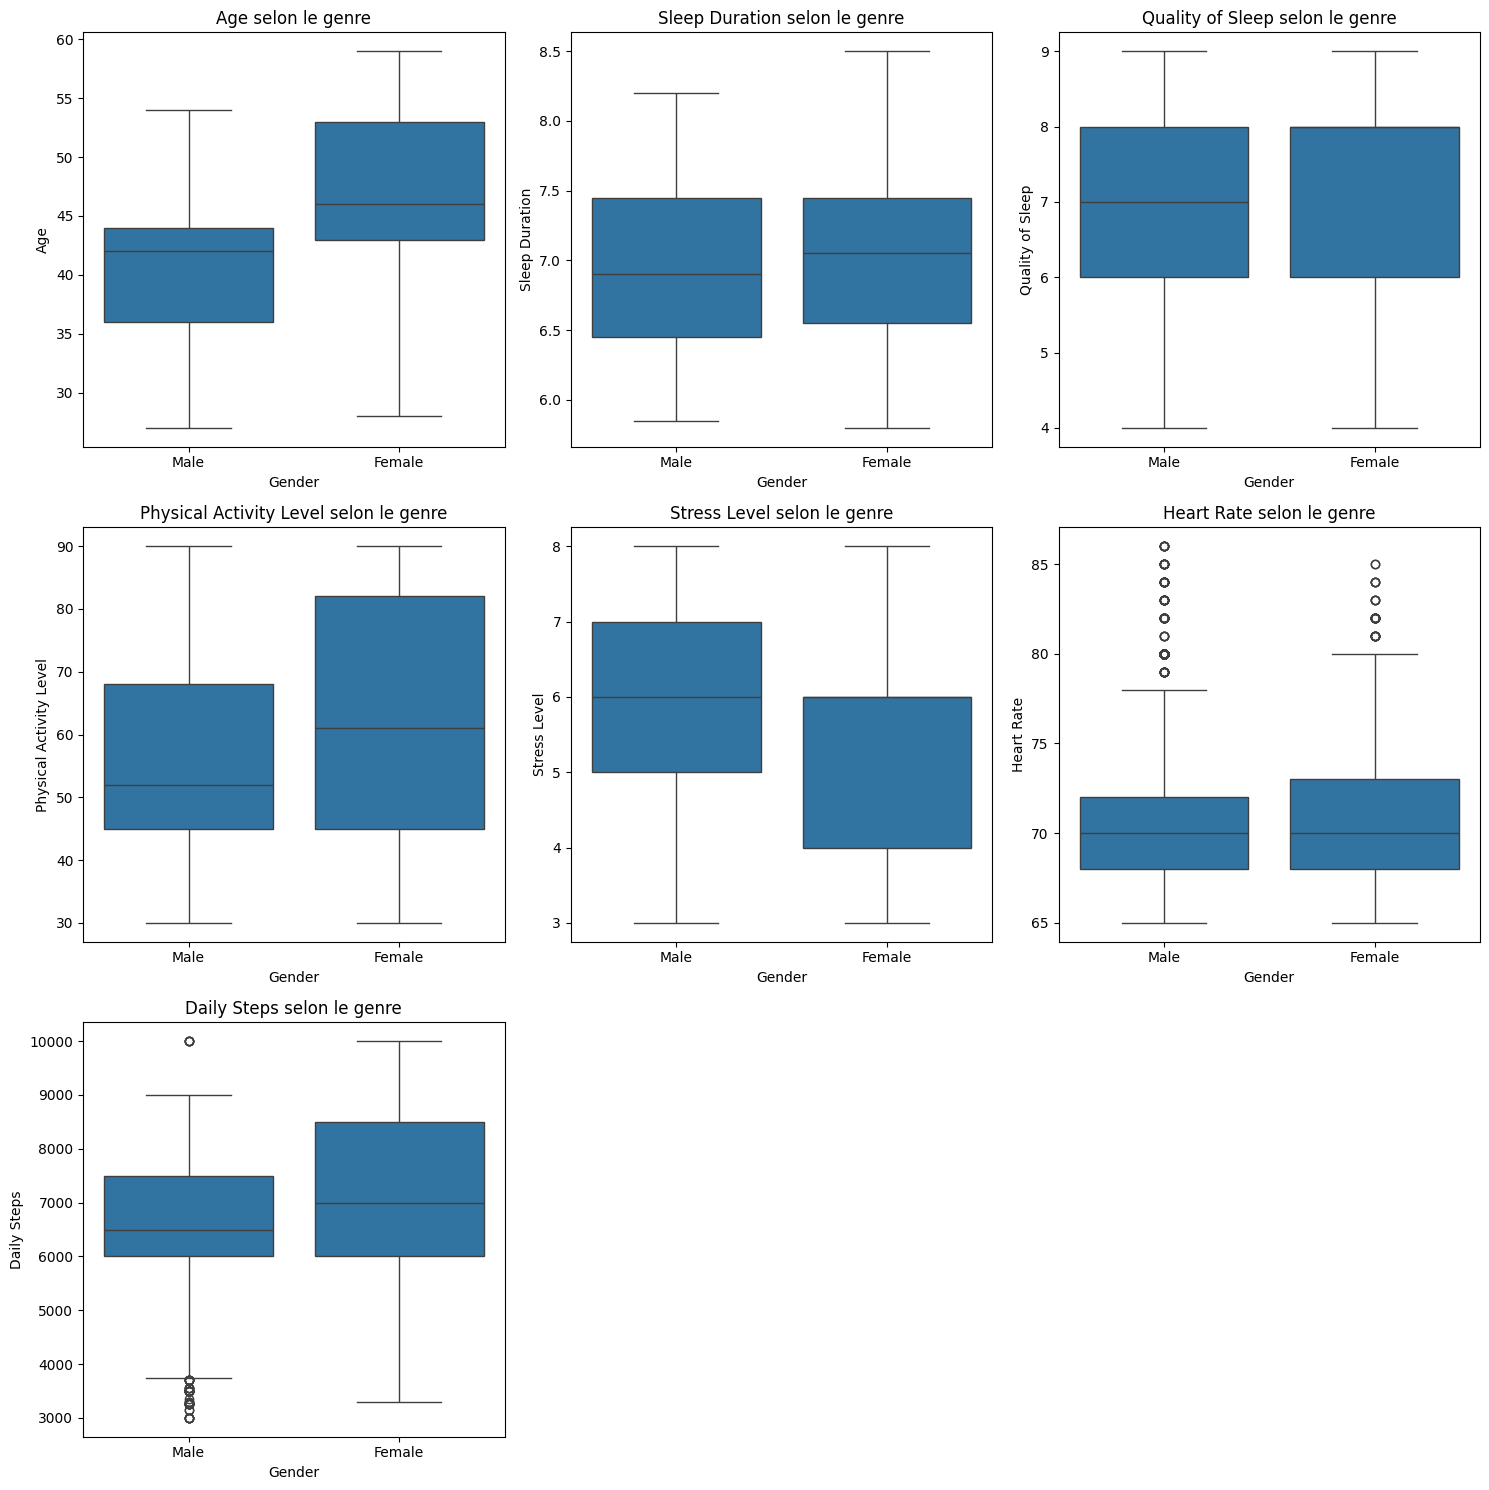

In [5]:
num_cols = len(numerical_cols)

rows = 3
cols = (num_cols + rows - 1) // rows

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(x='Gender', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{col} selon le genre')

# supprimer les axes vides si num_cols < rows*cols
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## 2.3. Heatmap de corrélation entre les variables numériques



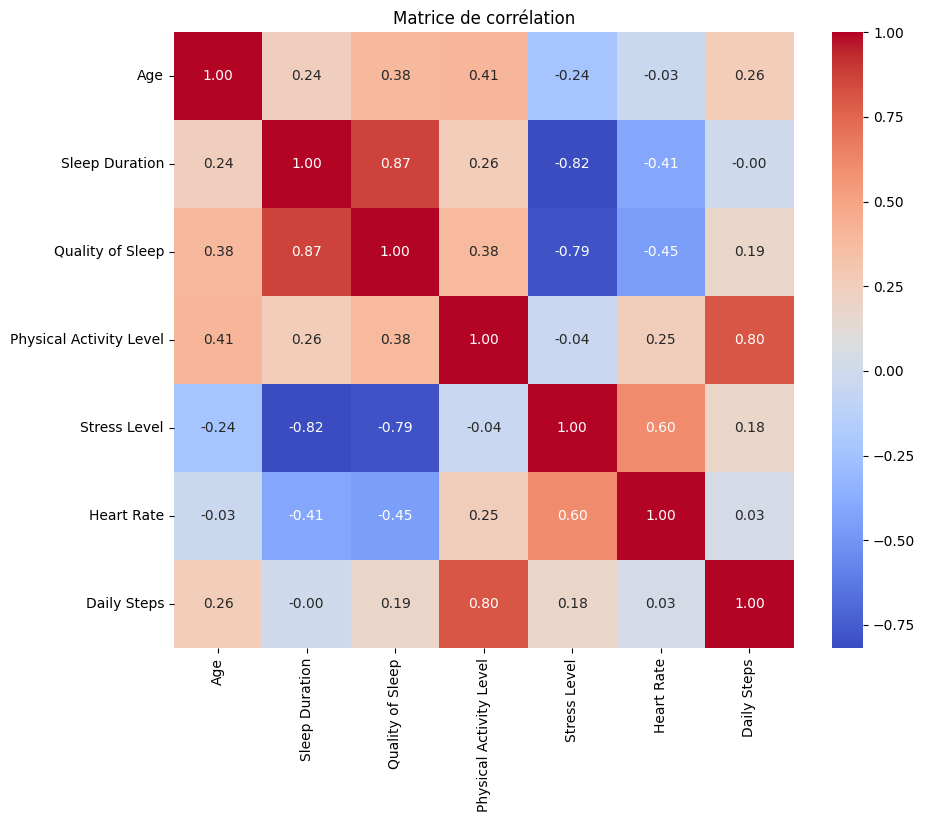

In [6]:
plt.figure(figsize=(10,8))
corr_matrix = df[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()

## 2.4. Comptage des Sleep Disorders par catégorie (bar plot)


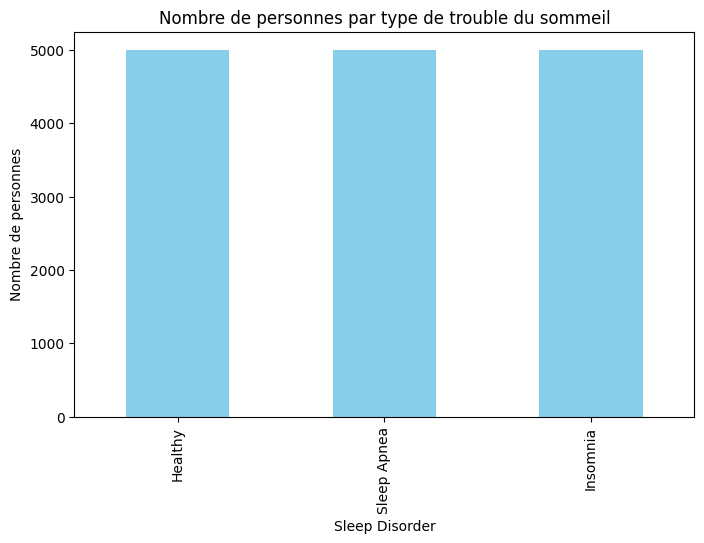

In [7]:
plt.figure(figsize=(8,5))
df['Sleep Disorder'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Nombre de personnes par type de trouble du sommeil")
plt.xlabel("Sleep Disorder")
plt.ylabel("Nombre de personnes")
plt.show()

# 3. Kmeans


## 3.1 Prétraitement des données (Preprocessing)

Nous allons transformer la colonne "Blood Pressure", encoder les variables catégoriques (comme le Genre ou l'Occupation) et mettre toutes les variables à la même échelle.

In [8]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# nettoyage et Feature Engineering
# séparer la pression sanguine en deux colonnes numériques
df[['Systolic', 'Diastolic']] = df['Blood Pressure'].str.split('/', expand=True).astype(int)

# sélection des colonnes pour le clustering
# on exclut 'Person ID' (inutile) et 'Blood Pressure' (remplacée)
features_to_use = [col for col in df.columns if col not in ['Person ID', 'Blood Pressure','Sleep disorder']]
# on retire 'Sleep Disorder' car on veut que le modèle le devine.

# séparation des types de colonnes
numeric_features = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level',
                    'Stress Level', 'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic']
categorical_features = ['Gender', 'Occupation', 'BMI Category']

# si 'Sleep Disorder' est vide ou NaN, on remplace par None pour le traiter comme une catégorie
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('None')
categorical_features.append('Sleep Disorder')

# création du Pipeline de transformation
# - Numérique : Standardisation (Moyenne 0, Ecart-type 1)
# - Catégorique : OneHotEncoding (Transformation en 0 et 1)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# application de la transformation
X_scaled = preprocessor.fit_transform(df)

print("Données prêtes pour le clustering. Forme de la matrice :", X_scaled.shape)

Données prêtes pour le clustering. Forme de la matrice : (15000, 29)


##  3.2 Méthode du Coude (Elbow Method)

Pour savoir combien de groupes (K) nous devons créer, nous allons tester de 1 à 10 clusters et regarder à quel moment l'inertie (la somme des erreurs au carré) cesse de diminuer rapidement.

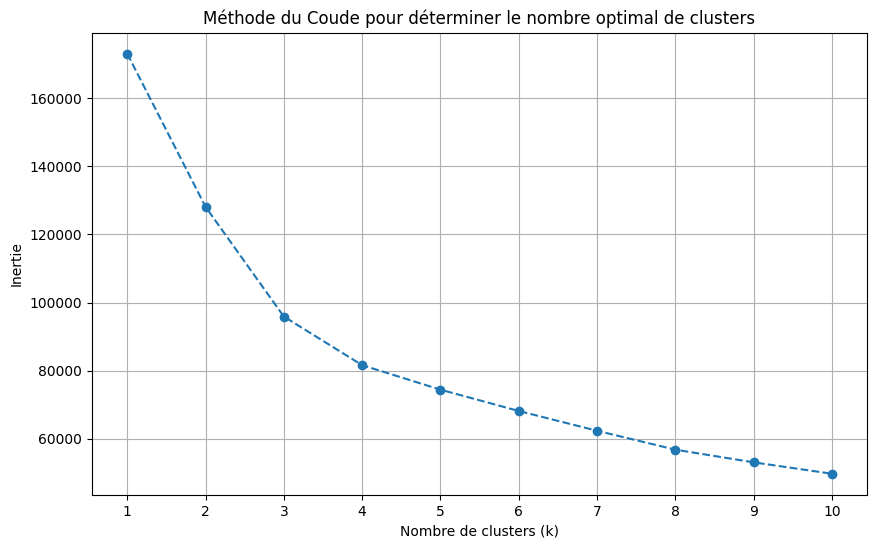

In [9]:
from sklearn.cluster import KMeans

# liste pour stocker l'inertie (somme des carrés des distances intra-cluster)
inertia = []
range_k = range(1, 11)

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range_k, inertia, marker='o', linestyle='--')
plt.title('Méthode du Coude pour déterminer le nombre optimal de clusters')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.xticks(range_k)
plt.grid(True)
plt.show()

## 3.3 Application du K-Means et Visualisation (PCA)

D'après la courbe (qui forme un coude autour de 3 ou 4), fixons arbitrairement k=3.

Nous utiliserons une ACP (Analyse en Composantes Principales) pour réduire les dimensions et visualiser les clusters en 2D.

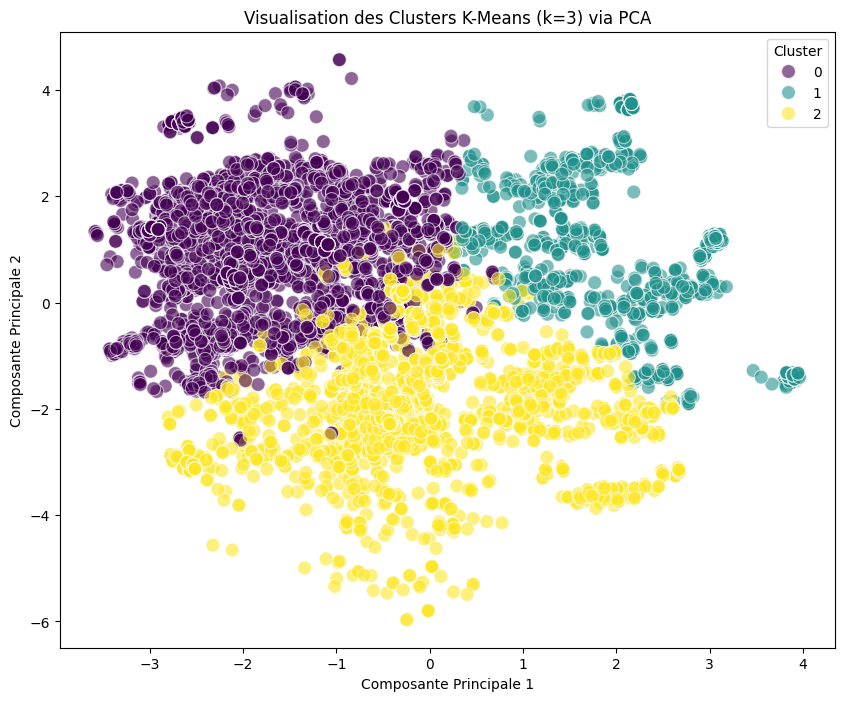

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# entraînement du modèle K-Means (si ce n'est pas déjà fait)
k_optimal = 3
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# ajout des clusters au dataframe original pour l'analyse
df['Cluster'] = clusters

# 2. visualisation avec PCA
pca = PCA(n_components=2)

# on vérifie si les données sont sparse ou non avant de convertir
if hasattr(X_scaled, 'toarray'):
    X_input = X_scaled.toarray()
else:
    X_input = X_scaled

X_pca = pca.fit_transform(X_input)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster'], palette='viridis', s=100, alpha=0.6)
plt.title(f'Visualisation des Clusters K-Means (k={k_optimal}) via PCA')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.legend(title='Cluster')
plt.show()

## 3.4 Interprétation des clusters

Enfin, regardons les statistiques moyennes de chaque groupe pour comprendre ce qu'ils représentent (ex: "Les sportifs peu stressés", "Les insomniaques âgés", etc.).

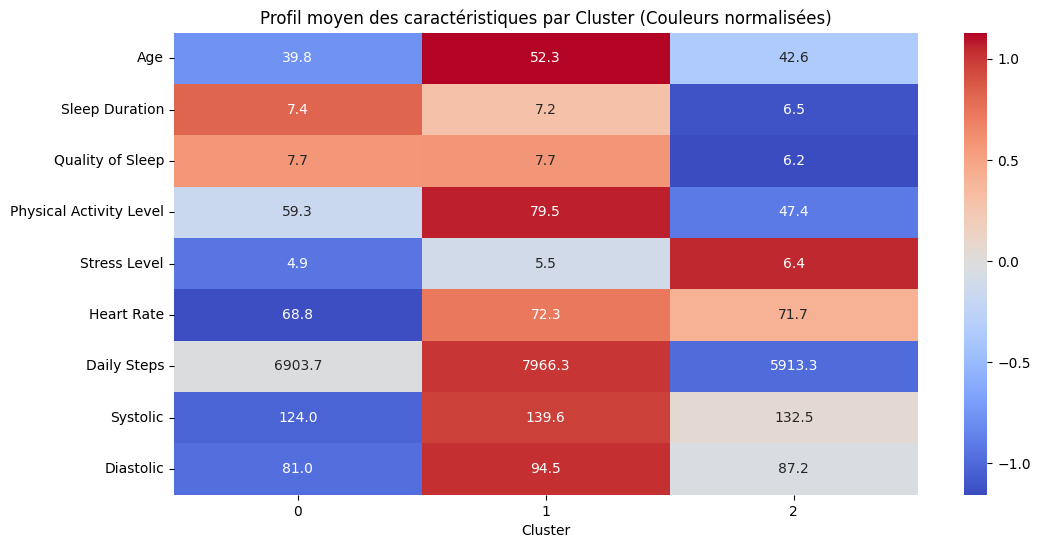

In [11]:
# interprétation des clusters
cluster_analysis = df.groupby('Cluster')[numeric_features].mean()

# on normalise les données juste pour l'affichage (Standardisation)
# (Valeur - Moyenne) / Ecart-type
cluster_analysis_scaled = (cluster_analysis - cluster_analysis.mean()) / cluster_analysis.std()

plt.figure(figsize=(12, 6))
# on utilise les données scaled pour les couleurs, mais on affiche les vrais chiffres (cluster_analysis) dans les cases
sns.heatmap(cluster_analysis_scaled.T, annot=cluster_analysis.T, cmap='coolwarm', fmt=".1f")
plt.title('Profil moyen des caractéristiques par Cluster (Couleurs normalisées)')
plt.show()

### Cluster 0 : Les "Jeunes en bonne santé"
Ce groupe représente l'idéal de santé dans votre jeu de données.
* Couleur dominante : Beaucoup de Bleu (valeurs basses) pour les indicateurs négatifs (Stress, Pression).
* Caractéristiques clés :
* * Âge : Les plus jeunes en moyenne (~40 ans).
* * Santé Cardiaque : Excellente. Pression artérielle la plus basse (124/81) et rythme cardiaque le plus bas (68.8).
* * Sommeil & Stress : Ils dorment bien (7.4h), ont une bonne qualité de sommeil (7.7/10) et sont les moins stressés (4.9).
* * Activité : Moyenne. Ils ne sont pas des athlètes, mais ils bougent suffisamment.

### Cluster 1 : Les "Seniors actifs mais hypertendus"
Ce groupe est très intéressant car il mélange de très bons et de moins bons indicateurs.
* Couleur dominante : Beaucoup de Rouge/Marron (valeurs élevées).
* Caractéristiques clés :
* * Âge : Le groupe le plus âgé (~52 ans).
* * Activité Physique : Ce sont les plus sportifs ! Record d'activité (79.5) et de pas quotidiens (~8000).
* * Pression Artérielle : C'est le point noir. Ils sont en hypertension (139/94). C'est probablement lié à l'âge, malgré le sport.
* * Sommeil : Ils dorment étonnamment bien (7.2h) avec une très bonne qualité, similaire aux jeunes.

### Cluster 2 : Les "Stressés à risque"
C'est le groupe qui devrait inquiéter un médecin.
* Couleur dominante : Un mélange contrasté (Bleu pour le sommeil/sport, Rouge pour le stress).
* Caractéristiques clés :
* * Sommeil : Catastrophique comparé aux autres. Durée courte (6.5h) et mauvaise qualité (6.2).
* * Stress : Le plus élevé du groupe (6.4).
* * Activité : Les plus sédentaires (niveau d'activité le plus bas à 47.4 et moins de 6000 pas).
* * Santé : Rythme cardiaque élevé et tension au-dessus de la normale (132/87).

## 3.5 Cohérence avec la colonne "Sleep Disorder" (Analyse croisée)
Jusqu'ici, le K-Means a créé des groupes basés sur les chiffres (Age, Stress, etc.) sans forcément regarder l'étiquette "Maladie du sommeil" (sauf si on l'a laissée dans le one-hot encoding, mais le K-Means ne la favorise pas).

Il est maintenant très intéressant de voir comment nos clusters se superposent à la réalité médicale. Est-ce que le Cluster 2 (Stressés) contient tous les insomniaques ?

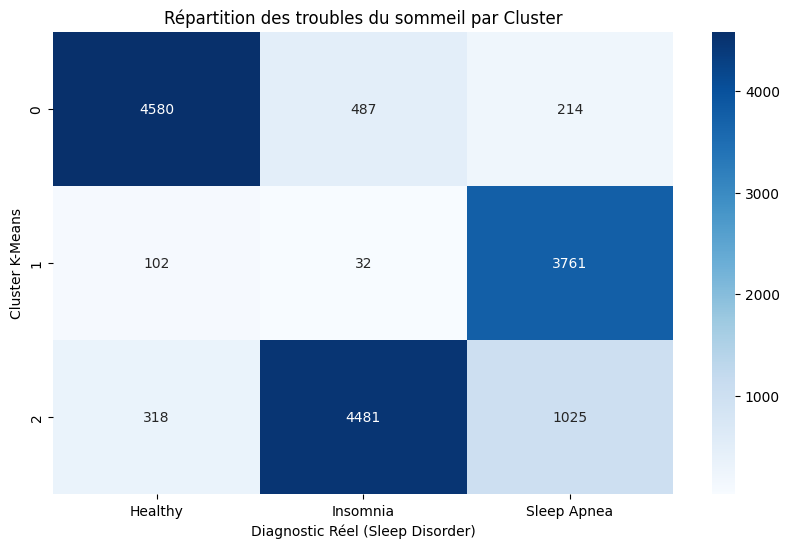

In [12]:
# Tableau croisé : Clusters vs Troubles du Sommeil
cross_tab = pd.crosstab(df['Cluster'], df['Sleep Disorder'])

# affichage avec une Heatmap pour voir les concentrations
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='Blues')
plt.title('Répartition des troubles du sommeil par Cluster')
plt.ylabel('Cluster K-Means')
plt.xlabel('Diagnostic Réel (Sleep Disorder)')
plt.show()

### Cluster 0 : Les "Sains" (Healthy)
* Le graphique montre : Une écrasante majorité de cas "Healthy" (4580).
* Lien avec l'étape précédente : C'était le groupe "Jeunes en bonne santé" avec une tension basse et peu de stress.
* Conclusion : Le modèle a parfaitement isolé les individus sans troubles.

### Cluster 1 : L'Apnée du sommeil (Sleep Apnea)
* Le graphique montre : Une très forte concentration de "Sleep Apnea" (3761).
* Lien avec l'étape précédente : C'était le groupe des "Seniors actifs" qui avait une Pression Artérielle (Systolic) très élevée.
* Conclusion médicale : C'est très cohérent. L'hypertension est l'un des symptômes majeurs et facteurs de risque de l'apnée du sommeil. Le modèle a détecté ce lien physiologique.

### Cluster 2 : L'Insomnie (Insomnia)
* Le graphique montre : Majoritairement des "Insomnia" (4481) (avec un peu d'apnée).
* Lien avec l'étape précédente : C'était le groupe "Stressés à risque" avec une durée de sommeil très courte et un stress élevé.
* Conclusion médicale : Le stress élevé et la faible durée de sommeil sont les signatures typiques de l'insomnie. Le clustering a  mis le doigt dessus.

# 4 Machine learning

## 4.1 Random forest

Entraînement du modèle en cours...

--- RÉSULTATS ---
Précision globale (Accuracy) : 96.53%

--- Rapport détaillé ---
              precision    recall  f1-score   support

     Healthy       0.96      0.96      0.96      1026
    Insomnia       0.97      0.96      0.97       997
 Sleep Apnea       0.97      0.97      0.97       977

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



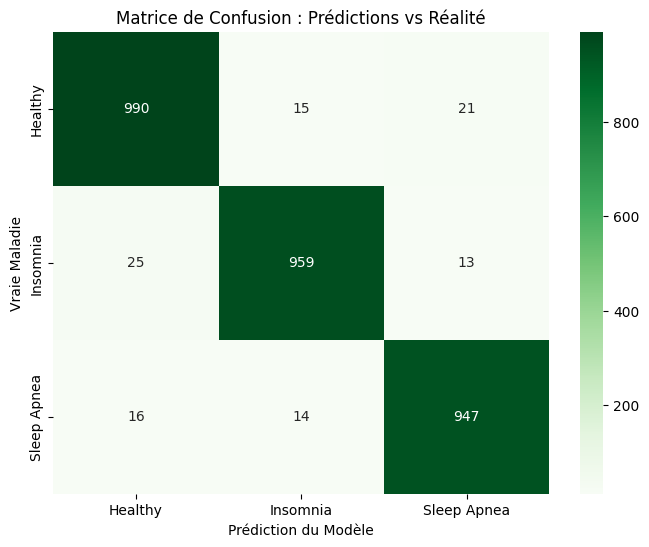

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# --- 1. PRÉPARATION DES DONNÉES ---

# on s'assure que la pression sanguine est bien séparée
if 'Systolic' not in df.columns:
    df[['Systolic', 'Diastolic']] = df['Blood Pressure'].str.split('/', expand=True).astype(int)

# DÉFINITION DE LA CIBLE (Ce qu'on veut deviner)
y = df['Sleep Disorder']

# DÉFINITION DES FEATURES (Les indices pour deviner)
# IMPORTANT : On enlève 'Person ID' (inutile), 'Blood Pressure' (déjà traité) et SURTOUT 'Sleep Disorder'
X_raw = df.drop(['Person ID', 'Blood Pressure', 'Sleep Disorder', 'Cluster'], axis=1, errors='ignore')

# identification des colonnes
numeric_features = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level',
                    'Stress Level', 'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic']
categorical_features = ['Gender', 'Occupation', 'BMI Category']

# création du transformateur
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# transformation des données
X = preprocessor.fit_transform(X_raw)

# --- 2. ENTRAÎNEMENT DU MODÈLE ---

# séparation : 80% pour apprendre (Train), 20% pour tester (Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# création et entraînement du modèle (Random Forest)
print("Entraînement du modèle en cours...")
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- 3. ÉVALUATION ---

# prédiction sur les données de test
y_pred = model.predict(X_test)

# résultats
print("\n--- RÉSULTATS ---")
print(f"Précision globale (Accuracy) : {accuracy_score(y_test, y_pred):.2%}")
print("\n--- Rapport détaillé ---")
print(classification_report(y_test, y_pred))

# visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Matrice de Confusion : Prédictions vs Réalité')
plt.ylabel('Vraie Maladie')
plt.xlabel('Prédiction du Modèle')
plt.show()

## 4.2 XGBoost et Gradiant Boosting

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# --- 1. PRÉPARATION SPÉCIALE POUR XGBOOST ---
# XGBoost a besoin que la cible soit des chiffres (0, 1, 2) et pas du texte
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# --- RANDOM FOREST (Votre référence actuelle) ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_score = rf_model.score(X_test, y_test)

# --- GRADIENT BOOSTING (Sklearn) ---
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_score = gb_model.score(X_test, y_test)

# --- XGBOOST (Le Challenger) ---
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train_encoded)
xgb_score = xgb_model.score(X_test, y_test_encoded)

# --- 2. COMPARAISON DES RÉSULTATS ---
scores = pd.DataFrame({
    'Modèle': ['Random Forest', 'Gradient Boosting', 'XGBoost'],
    'Précision': [rf_score, gb_score, xgb_score]
})

print(scores.sort_values(by='Précision', ascending=False))

winner = scores.sort_values(by='Précision', ascending=False).iloc[0]
print(f"\nLe meilleur est : {winner['Modèle']} avec {winner['Précision']:.2%} de précision.")

              Modèle  Précision
2            XGBoost   0.975000
0      Random Forest   0.965333
1  Gradient Boosting   0.961333

Le meilleur est : XGBoost avec 97.50% de précision.


## 4.3 Hyperparameter Tuning XGBoost

Recherche des meilleurs paramètres en cours... (Cela peut prendre quelques secondes)
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Meilleurs paramètres trouvés : {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Nouvelle précision (Accuracy) : 97.57%


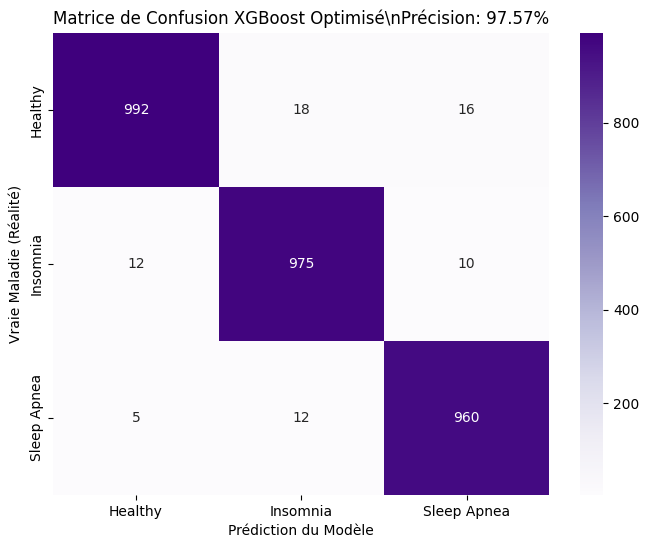

              precision    recall  f1-score   support

     Healthy       0.98      0.97      0.97      1026
    Insomnia       0.97      0.98      0.97       997
 Sleep Apnea       0.97      0.98      0.98       977

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. DÉFINITION DE LA GRILLE DE PARAMÈTRES ---
# On va tester plusieurs combinaisons pour trouver la "recette" parfaite
param_grid = {
    'n_estimators': [100, 200],        # Nombre d'arbres (plus n'est pas toujours mieux)
    'learning_rate': [0.01, 0.1, 0.2], # Vitesse d'apprentissage (pas trop vite, pas trop lent)
    'max_depth': [3, 5, 7],            # Profondeur des arbres (éviter le sur-apprentissage)
    'subsample': [0.8, 1.0]            # Pourcentage de données utilisées pour chaque arbre
}

# --- 2. RECHERCHE DES MEILLEURS PARAMÈTRES (GRID SEARCH) ---
print("Recherche des meilleurs paramètres en cours... (Cela peut prendre quelques secondes)")

xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)

# GridSearchCV va tester toutes les combinaisons (Cross-Validation cv=3)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train_encoded)

# Récupération du meilleur modèle
best_xgb = grid_search.best_estimator_

print(f"\nMeilleurs paramètres trouvés : {grid_search.best_params_}")

# --- 3. PRÉDICTIONS ET ÉVALUATION ---
y_pred_encoded = best_xgb.predict(X_test)

# Calcul du score
new_score = accuracy_score(y_test_encoded, y_pred_encoded)
print(f"Nouvelle précision (Accuracy) : {new_score:.2%}")

# --- 4. VISUALISATION DE LA MATRICE DE CONFUSION ---
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_encoded, y_pred_encoded)

# On utilise le LabelEncoder (le) pour remettre les vrais noms (Healthy, Sleep Apnea...)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.title(f'Matrice de Confusion XGBoost Optimisé\\nPrécision: {new_score:.2%}')
plt.ylabel('Vraie Maladie (Réalité)')
plt.xlabel('Prédiction du Modèle')
plt.show()

# Affichage du rapport détaillé
print(classification_report(y_test_encoded, y_pred_encoded, target_names=le.classes_))

## 4.4 Hyperparameter Tuning Random Forest


Optimisation du Random Forest en cours...
Fitting 3 folds for each of 54 candidates, totalling 162 fits

Meilleurs paramètres Random Forest : {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Précision Random Forest Optimisé : 96.73%


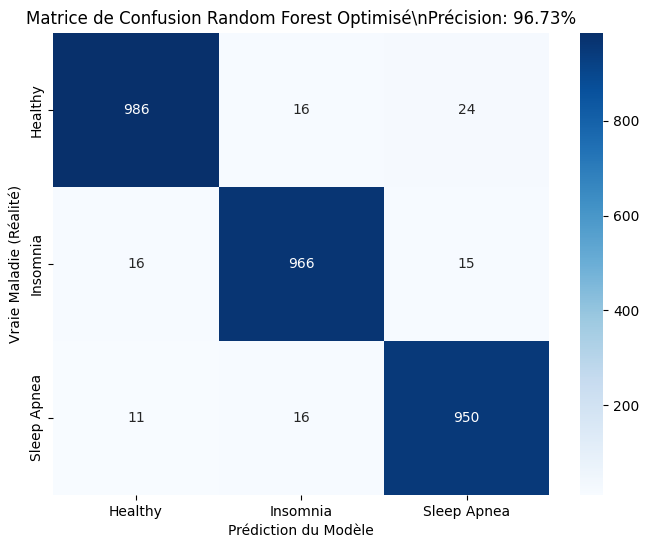

              precision    recall  f1-score   support

     Healthy       0.97      0.96      0.97      1026
    Insomnia       0.97      0.97      0.97       997
 Sleep Apnea       0.96      0.97      0.97       977

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. DÉFINITION DE LA GRILLE DE PARAMÈTRES (Spécifique au Random Forest) ---
param_grid_rf = {
    'n_estimators': [50, 100, 200],      # Nombre d'arbres
    'max_depth': [None, 10, 20],         # Profondeur max (None = illimité, attention au sur-apprentissage)
    'min_samples_split': [2, 5, 10],     # Combien d'échantillons min pour diviser un nœud
    'criterion': ['gini', 'entropy']     # La méthode de calcul de l'impureté
}

# --- 2. RECHERCHE DES MEILLEURS PARAMÈTRES ---
print("Optimisation du Random Forest en cours...")

rf = RandomForestClassifier(random_state=42)

# On utilise les données encodées (y_train_encoded) pour rester cohérent avec l'étape précédente
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train_encoded)

# Récupération du meilleur modèle
best_rf = grid_search_rf.best_estimator_

print(f"\nMeilleurs paramètres Random Forest : {grid_search_rf.best_params_}")

# --- 3. PRÉDICTIONS ET ÉVALUATION ---
y_pred_rf_encoded = best_rf.predict(X_test)

# Calcul du score
rf_opt_score = accuracy_score(y_test_encoded, y_pred_rf_encoded)
print(f"Précision Random Forest Optimisé : {rf_opt_score:.2%}")

# --- 4. VISUALISATION DE LA MATRICE DE CONFUSION ---
plt.figure(figsize=(8, 6))
cm_rf = confusion_matrix(y_test_encoded, y_pred_rf_encoded)

# On utilise 'Blues' pour le distinguer visuellement du XGBoost (qui était en 'Purples')
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.title(f'Matrice de Confusion Random Forest Optimisé\\nPrécision: {rf_opt_score:.2%}')
plt.ylabel('Vraie Maladie (Réalité)')
plt.xlabel('Prédiction du Modèle')
plt.show()

# Rapport détaillé
print(classification_report(y_test_encoded, y_pred_rf_encoded, target_names=le.classes_))

## 4.5 Comparaison des deux

--- CLASSEMENT FINAL ---
                     Modèle  Précision
4        XGBoost (Optimisé)   0.975667
3            XGBoost (Base)   0.975000
1  Random Forest (Optimisé)   0.967333
0      Random Forest (Base)   0.965333
2  Gradient Boosting (Base)   0.961333


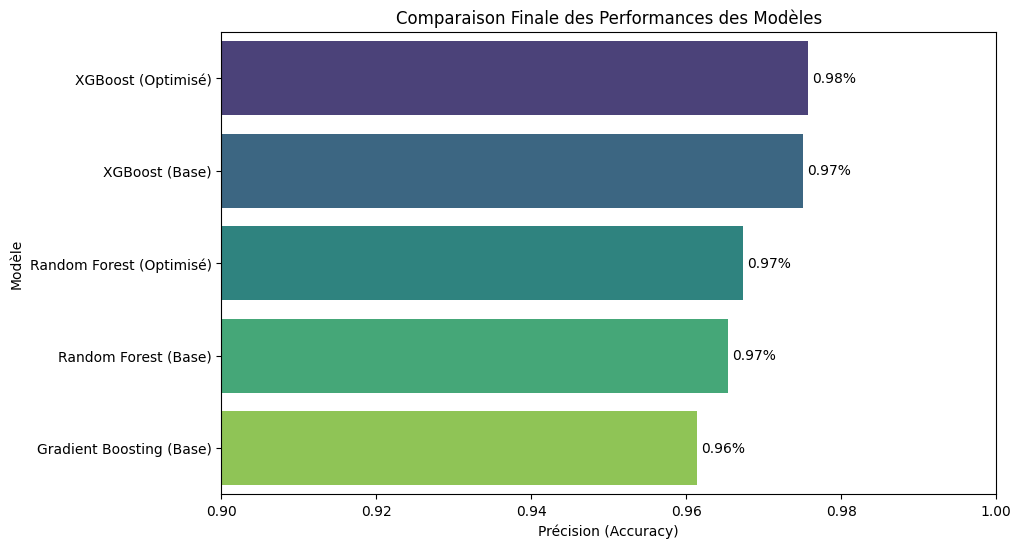


Le modèle champion est : XGBoost (Optimisé) avec une précision de 97.57%


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. RASSEMBLEMENT DES SCORES (Récupération des variables précédentes) ---
# Note : Assurez-vous d'avoir exécuté les blocs précédents pour avoir rf_score, rf_opt_score, etc.
resultats = {
    'Modèle': [
        'Random Forest (Base)',
        'Random Forest (Optimisé)',
        'Gradient Boosting (Base)',
        'XGBoost (Base)',
        'XGBoost (Optimisé)'
    ],
    'Précision': [
        rf_score,
        rf_opt_score,
        gb_score,
        xgb_score,
        new_score
    ]
}

# Création du DataFrame
df_scores = pd.DataFrame(resultats)

# Tri des résultats du meilleur au moins bon
df_scores = df_scores.sort_values(by='Précision', ascending=False)

# --- 2. AFFICHAGE DU TABLEAU ---
print("--- CLASSEMENT FINAL ---")
print(df_scores)

# --- 3. VISUALISATION GRAPHIQUE CORRIGÉE ---
plt.figure(figsize=(10, 6))

# Création d'un barplot avec la correction pour éviter le Warning
# On ajoute hue='Modèle' et legend=False
ax = sns.barplot(x='Précision', y='Modèle', hue='Modèle', data=df_scores, palette='viridis', legend=False)

# Ajout des pourcentages sur les barres
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f%%', padding=3)

plt.title('Comparaison Finale des Performances des Modèles')
plt.xlabel('Précision (Accuracy)')
plt.xlim(0.9, 1.0)  # Zoom sur les scores entre 90% et 100%
plt.show()

# --- 4. LE VAINQUEUR ---
gagnant = df_scores.iloc[0]
print(f"\nLe modèle champion est : {gagnant['Modèle']} avec une précision de {gagnant['Précision']:.2%}")

In [18]:
from xgboost import XGBClassifier

# Initialisation du modèle avec les meilleurs paramètres
best_xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.2,
    max_depth=5,
    subsample=1.0,
    eval_metric='mlogloss',
    random_state=42
)

# Entraînement
best_xgb_model.fit(X_train, y_train_encoded)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


# 5 Vérification du meilleur modèle (XGBoost)

## 5.1 Interprétabilité du modèle (Feature Importance)

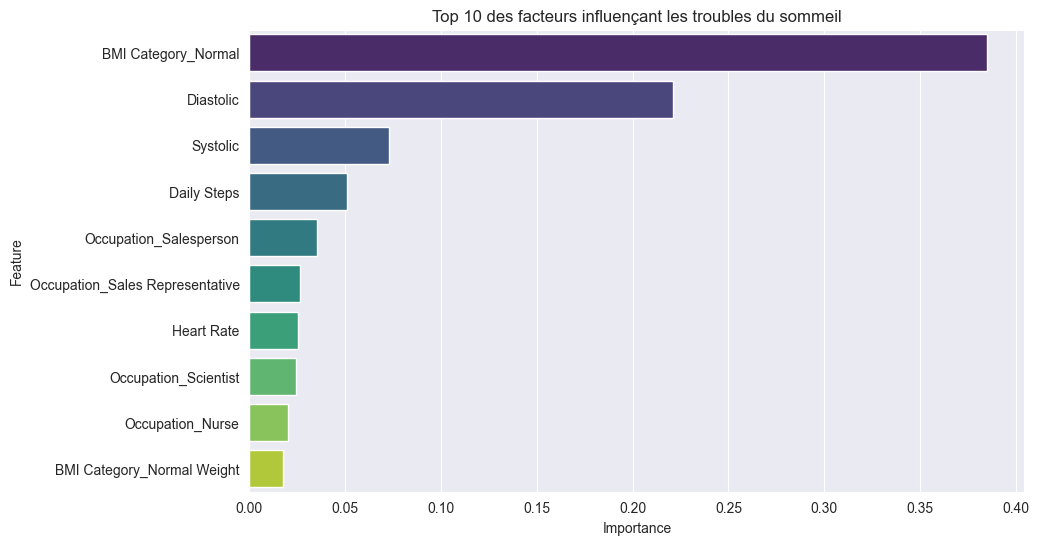

In [19]:
feature_importances = grid_search.best_estimator_.feature_importances_

# Pour avoir les noms des colonnes après le OneHotEncoding
# (Nécessite d'accéder aux noms via le preprocessor)
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_features = numeric_features + list(cat_features)

feat_imp_df = pd.DataFrame({'Feature': all_features, 'Importance': feature_importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feat_imp_df,
    hue='Feature',
    legend=False,
    palette='viridis'
)
plt.title('Top 10 des facteurs influençant les troubles du sommeil')
plt.show()

## 5.2 Analyse des erreurs

<Figure size 800x600 with 0 Axes>

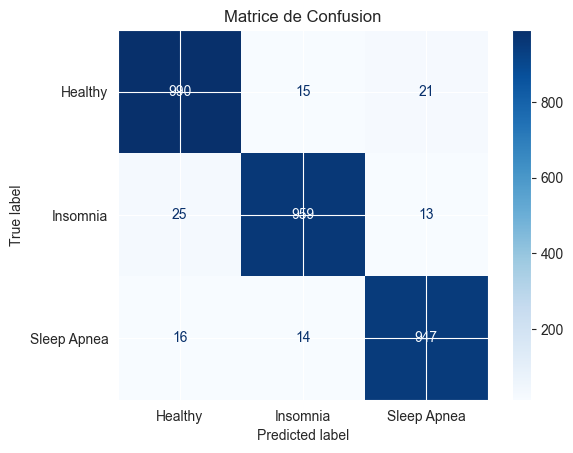

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcul de la matrice
cm = confusion_matrix(y_test, y_pred)

# Affichage
plt.figure(figsize=(8, 6))

# le.classes_ permet d'afficher les vrais noms (None, Insomnia, Sleep Apnea) au lieu de 0, 1, 2
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Matrice de Confusion')
plt.show()

# 6 Prédiction

In [21]:
# Supposons que model_pipeline est le pipeline complet (Preprocessing + Modèle) déjà entraîné

def diagnostiquer_patient(age, gender, occupation, sleep_duration, quality_sleep,
                          physical_activity, stress_level, bmi_category,
                          heart_rate, daily_steps, systolic, diastolic):

    # 1. Création des données brutes
    data = {
        'Gender': [gender],
        'Age': [age],
        'Occupation': [occupation],
        'Sleep Duration': [sleep_duration],
        'Quality of Sleep': [quality_sleep],
        'Physical Activity Level': [physical_activity],
        'Stress Level': [stress_level],
        'BMI Category': [bmi_category],
        'Heart Rate': [heart_rate],
        'Daily Steps': [daily_steps],
        'Systolic': [systolic],
        'Diastolic': [diastolic]
    }

    new_patient_df = pd.DataFrame(data)

    # 2. Prédiction directe via la pipeline
    try:
        prediction_encoded = model_pipeline.predict(new_patient_df)

        # 3. DÉCODAGE
        diagnostic = le.inverse_transform(prediction_encoded)
        return diagnostic[0]

    except Exception as e:
        return f"Erreur lors de la prédiction : {str(e)}"

In [22]:
resultat_A = diagnostiquer_patient(
    age=25,
    gender='Male',
    occupation='Software Engineer',
    sleep_duration=7.5,
    quality_sleep=8,
    physical_activity=60,
    stress_level=4,
    bmi_category='Normal',
    heart_rate=70,
    daily_steps=8000,
    systolic=120,
    diastolic=80
)

print(f"Diagnostic du patient A : {resultat_A}")
# On espère : "Healthy"

Diagnostic du patient A : Healthy


In [23]:
resultat_B = diagnostiquer_patient(
    age=50,
    gender='Male',
    occupation='Sales Representative',
    sleep_duration=5.5,
    quality_sleep=4,
    physical_activity=30,
    stress_level=8,
    bmi_category='Obese',
    heart_rate=95,
    daily_steps=3000,
    systolic=140,
    diastolic=95
)

print(f"Diagnostic du patient B : {resultat_B}")
# On s'attend à : "Sleep Apnea" ou "Insomnia"

Diagnostic du patient B : Insomnia


In [24]:
resultat_B = diagnostiquer_patient(
    age=40,
    gender='Male',
    occupation='Doctor',
    sleep_duration=7,
    quality_sleep=7,
    physical_activity=45,
    stress_level=5,
    bmi_category='Normal',
    heart_rate=70,
    daily_steps=5000,
    systolic=120,
    diastolic=80
)

print(f"Diagnostic du patient C : {resultat_B}")

Diagnostic du patient C : Healthy


## 6.1 Créer le modèle

In [25]:
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

print("--- DÉBUT DE LA GÉNÉRATION DU MODÈLE ---")

# 1. Chargement
try:
    df = pd.read_csv("Sleep_Data_Sampled.csv")
    print("Dataset chargé.")
except FileNotFoundError:
    print("ERREUR : 'Sleep_Data_Sampled.csv' introuvable.")
    exit()

# ---------------------------------------------------------
if 'BMI Category' in df.columns:
    # On fusionne 'Normal Weight' dans 'Normal' pour n'avoir qu'une seule catégorie
    df['BMI Category'] = df['BMI Category'].replace('Normal Weight', 'Normal')
    print("Fusion effectuée : 'Normal Weight' -> 'Normal'")
# ---------------------------------------------------------

# Gestion de la tension (Split)
if 'Blood Pressure' in df.columns:
    df[['Systolic', 'Diastolic']] = df['Blood Pressure'].str.split('/', expand=True).astype(int)

# 3. Préparation des colonnes
numeric_features = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level',
                    'Stress Level', 'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic']
# Note : Maintenant 'BMI Category' ne contient plus que 'Normal', 'Overweight', 'Obese'
categorical_features = ['Gender', 'Occupation', 'BMI Category']

X = df.drop(columns=['Person ID', 'Blood Pressure', 'Sleep Disorder'], errors='ignore')
y = df['Sleep Disorder']

# 4. Encodage de la cible (None, Insomnia, Sleep Apnea) -> (0, 1, 2)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"Classes détectées : {list(le.classes_)}")
# Vérifiez bien que 'None' est dedans.

# 5. Création du Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# On reprend les hyperparamètres qui marchaient bien
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        eval_metric='mlogloss'
    ))
])

# 6. Entraînement
print("Entraînement en cours...")
model_pipeline.fit(X, y_encoded)
score = model_pipeline.score(X, y_encoded)
print(f"Précision sur le dataset complet : {score:.2%}")

# 7. Sauvegarde
artifacts = {
    'model': model_pipeline,
    'label_encoder': le
}

joblib.dump(artifacts, 'sleep_model_artifacts.pkl')
print("FICHIER 'sleep_model_artifacts.pkl' GÉNÉRÉ AVEC SUCCÈS !")

--- DÉBUT DE LA GÉNÉRATION DU MODÈLE ---
Dataset chargé.
Fusion effectuée : 'Normal Weight' -> 'Normal'
Classes détectées : ['Healthy', 'Insomnia', 'Sleep Apnea']
Entraînement en cours...
Précision sur le dataset complet : 97.86%
FICHIER 'sleep_model_artifacts.pkl' GÉNÉRÉ AVEC SUCCÈS !
